In [39]:
import pandas as pd
import numpy as np
from finance_byu.summarize import summary
from datetime import date, datetime, timedelta
from scipy import fftpack
from scipy.stats import ttest_ind
from matplotlib import pyplot as plt
from finance_byu.regtables import Regtable
import statsmodels.formula.api as smf
from numba import jit
from scipy import stats

### Load in the Data
Lesson learned: 
1. .reset_index(drop=True) is NECESSARY!! for any filtering
2. must filter on price_lag
3. performance improves if absolute value of prices
4. performance improves if price is filtered during portfolio construction

In [40]:
def load_data(filename, price_lim=None, date_start=None, date_end = None, monthly=False):
    # Step 1: Load data
    df = pd.read_csv(filename)
    
    # Step 2: Clean and convert non-numeric values
    # Check b and c for ret
    df['RET'] = pd.to_numeric(df['RET'].replace(['B', 'C'], np.nan), errors='coerce')

    # Step 3: Convert data types for memory efficiency
    df['PERMNO'] = df['PERMNO'].astype('int32')
    df['PRC'] = df['PRC'].astype('float32')
    df['SHROUT'] = df['SHROUT'].astype('float32')
    df['RET'] = df['RET'].astype('float32')
    
    # Step 4: Convert date to datetime and adjust for monthly data if specified
    df['date'] = pd.to_datetime(df['date'])
    if monthly:
        df['date'] += pd.offsets.MonthEnd(0)
    
    # Step 5: Rename columns for clarity
    df.rename(columns={'PERMNO': 'permno', 'RET': 'ret', 'PRC': 'prc', 
                       'SHROUT': 'shrout'}, inplace=True)
    
    # Step 6: Make sure data is sorted by permno and date
    df.sort_values(['permno', 'date'], inplace=True)

    # Step 7: Handle negative prices and get price lags
    df['prc'] = df['prc'].abs()
    df['prc_lag'] = df.groupby('permno')['prc'].shift(1)
    
    # Step 8: Filter data based on price_lim
    if price_lim is not None:
        df = df[df['prc_lag'] > price_lim].reset_index(drop=True)
    
    # Step 9: If date_lim is specified, filter data
    if date_start is not None:
        df = df[df['date'] > date_start].reset_index(drop=True)
    if date_end is not None:
        df = df[df['date'] < date_end].reset_index(drop=True)
    
    # Step 10: Calculate derived columns: market cap and adjusted returns
    df['market_cap'] = df['prc'] * df['shrout'] * 1000
    df['market_cap_lag'] = df.groupby('permno')['market_cap'].shift(1)
    
    # Return cleaned data
    return df


def load_factor(filename, main_df, subset = ['rf'], monthly=False):
    # Step 1: Load data
    factors = pd.read_csv(filename)
    if monthly:
        factors['date'] = pd.to_datetime(factors['date'], format='%Y%m') + pd.offsets.MonthEnd(0)
    else:
        factors['date'] = pd.to_datetime(factors['date'], format='%Y%m%d')
        
    # Step 2: scale non-date columns
    for col in subset:
        factors[col] = factors[col] / 100
    
    # Step 3: Merge subset onto main data
    main_df = main_df.merge(factors[['date'] + subset], how='left', on='date')
    
    # return merged data
    return main_df.reset_index(drop=True)

In [41]:
# month = load_data('crsp_m.csv', price_lim=5, monthly=True) #, date_lim='1970-01-01')
day = load_data('crsp_d.csv', price_lim=5, monthly=False, date_start='1980-01-01', date_end='2007-12-31')
day = load_factor('fama_d.csv', day, subset=['rf'])
df_daily = day.copy()

In [42]:
# # Performance Issues: prc absolute, price filter during portfolio formation
# # Catestrophic Issues: .reset_index(drop=True) was not included in the load_data function
    
# # Load in with the custom function
# month = load_data('crsp_m.csv', monthly=True)

# # Make the momentum portfolio
# month['logret'] = np.log(1 + month['ret'])
# month['mom'] = month.groupby('permno')['logret'].rolling(11,11).sum().reset_index(drop=True)
# month['mom'] = month.groupby('permno')['mom'].shift(2)
# month.dropna(subset=['mom'], inplace=True)
# month = month[month['prc_lag'] >= 5].reset_index(drop=True)

# # Form the portfolios
# month['bins'] = month.groupby('date')['mom'].transform(pd.qcut,5,labels=False)
# port = month.groupby(['date','bins'])['ret'].mean().unstack(level='bins') * 100
# port['spread'] = port[4] - port[0]
# summary(port).round(4)
display(df_daily.head())

,permno,date,prc,ret,shrout,prc_lag,market_cap,market_cap_lag,rf
0,10001,1986-01-10,5.8750,0.021739,985.0,5.7500,5786875.0,NaN,0.00025
1,10001,1986-01-13,5.8750,0.000000,985.0,5.8750,5786875.0,5786875.0,0.00025
2,10001,1986-01-14,5.8750,0.000000,985.0,5.8750,5786875.0,5786875.0,0.00025
3,10001,1986-01-15,6.0625,0.031915,985.0,5.8750,5971562.5,5786875.0,0.00025
4,10001,1986-01-16,6.2500,0.030928,985.0,6.0625,6156250.0,5971562.5,0.00025


### Signal Functions

In [43]:
@jit
def momentum(samples, window_start=22, window_end=252):
    # Preallocate the output array with NaNs for the initial window_end period
    result = np.full(len(samples), np.nan)
    window_size = window_end - window_start + 1
    
    # If the sample is larger than the window, calculate the momentum
    if len(samples) > window_end:
        for i in range(len(samples) - window_end):
            result[i + window_end] = np.log1p(samples[i:i + window_size]).sum()
    
    # Return the result
    return result


@jit
def frog(returns, price, window_start=22, window_end=252):
    # Preallocate the output array with NaNs for the initial window_end period
    result = np.full(len(returns), np.nan)
    window_size = window_end - window_start + 1
    group_length = len(returns)

    # If the sample is larger than the window, get the formation period
    if group_length > window_end:
        for i in range(group_length - window_end):
            returns_formation_period = returns[i:i + window_size]

            # Calculate the sign of the formation return by comparing the first and last prices
            p0, pf = price[i], price[i + window_size-1]
            if pf > p0:
                sign = 1
            elif pf == p0:
                sign = 0
            else:
                sign = -1
            
            # Calculate the percentage of positive returns in the formation period
            positive = np.sum(returns_formation_period>=0)/window_size

            # Calculate the FROG by taking the sign, multiplied by neg - positive. (neg = 1 - positive)
            result[i + window_end] = sign * (1 - 2*positive)
            
    # Return the result
    return result


def get_id(df, window_start=22, window_end=252):
    # Get the returns, price, and index
    returns = df['ret'].values
    price = df['prc'].values
    index = df.index
    
    # calculate the frog
    id = frog(returns, price, window_start, window_end)
    
    # Add the ID to the dataframe
    return pd.Series(id, index=index)
    

### Portfolio Functions

In [44]:
# make portfolios yearly returns
def annualize(port, freq=252):
    # Get the mean, std, and count
    returns = port.mean(axis=0)
    std = port.std(ddof=1, axis=0)
    count = port.count(axis=0)
    
    # Annualize the returns and std
    returns = np.expm1(freq*np.log1p(returns))
    std = np.sqrt(freq)*std
    
    # Get the standard error, t-statistic, and p-values
    standard_error = std/np.sqrt(count)
    tstat = returns/standard_error
    p_values = 2 * stats.t.sf(np.abs(tstat), count - 1)
    
    # Return the results
    return returns, std, count, tstat, p_values


def summarize_port(ports, bins=5, freq = 252, signal1 = 'mom', signal2 = 'id'):
    # Get the portfolio mean, std, and count
    returns, std, count, tstat, p_values = annualize(ports, freq=freq)
    
    # Get the right column names and index for the DataFrames
    columns = [f'{signal1}_{i}' for i in range(1, bins + 1)] + ['Spread']
    index = [f'{signal2}_{i}' for i in range(1, bins + 1)]
    
    # Turn the results into DataFrames
    returns = pd.DataFrame(returns.values.reshape(bins+1,bins).T, columns=columns, index=index)
    std = pd.DataFrame(std.values.reshape(bins+1,bins).T, columns=columns, index=index)
    count = pd.DataFrame(count.values.reshape(bins+1,bins).T, columns=columns, index=index)
    tstat = pd.DataFrame(tstat.values.reshape(bins+1,bins).T, columns=columns, index=index)
    p_values = pd.DataFrame(p_values.reshape(bins+1,bins).T, columns=columns, index=index)
    
    # Return the results
    return returns, std, count, tstat, p_values


def get_spread(ports, bins=5, signal1 = 'mom', signal2 = 'id'):
    # Get the portfolio labels and loop through all the signal bins to find the momentum spread
    port_names = ports.columns.tolist()
    for i in range(1, bins + 1):
        
        # Determine the portolio starting and ending variable names
        ending = signal2[:2]+str(i)
        low_beginning = signal1[:2]+str(1)
        high_beginning = signal1[:2]+str(bins)
        
        # get the subset of port_names that ends with ending for both low and high
        low = [name for name in port_names if name.endswith(ending) and name.startswith(low_beginning)][0]
        high = [name for name in port_names if name.endswith(ending) and name.startswith(high_beginning)][0]
        
        # Get the spread
        spread_name = 'spread_' + ending
        ports[spread_name] = ports[high] - ports[low]
        
    # Return the results
    return ports

def display_double(results):
    for key, value in results.items():
        if key == 'Count':
            continue
        elif key == 'Return':
            value = value * 100
        elif key == 'Std':
            value = value * 100
        print(key)
        display(value.round(4))

In [45]:
def single_sort(df, signal_name = 'id', bins=5, sharpe = False, price_lim=5, freq = 252):
    # Copy the DataFrame and drop NaNs
    df = df.copy()
    df.dropna(subset=[signal_name, 'ret'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    signal_bins_name = signal_name + '_bins'
    
    # Filter data based on price limit
    df = df[df['prc_lag'] > price_lim].reset_index(drop=True)
    
    # Sort the bins according to the sequence
    df[signal_bins_name] = df.groupby('date')[signal_name].transform(lambda x: pd.qcut(x, bins, labels=False, duplicates='drop') + 1)
    
    # Get the columns and index for the results dataframe
    columns = [f'{signal_name}_{i}' for i in range(1, bins + 1)] + ['Spread']
    
    if not sharpe:
        # Get the portfolio labels
        ports = df.groupby(['date', signal_bins_name])['ret'].mean().unstack(level=signal_bins_name)
        ports['spread'] = ports[5] - ports[1]
        index = ['Return', 'Std', 'Count', 'T-stat', 'P-value']
    
        # Get the returns, std, count, tstat, and p_values
        rets, std, count, tstat, p_values = annualize(ports,freq=freq)
                
        # Put the results into a dataframe and return the results
        return pd.DataFrame(np.array([rets.values, std.values, count.values, tstat.values, p_values]), columns=columns, index=index)

    # Repeat if the sharpe is true, taking excess returns, and continuing in the same process
    else:
        df['exc_ret'] = df['ret'] - df['rf']
        excess_ports = df.groupby(['date', signal_bins_name])['exc_ret'].mean().unstack(level=signal_bins_name)
        excess_ports['spread'] = excess_ports[5] - excess_ports[1]
        
        # Get the returns, std, count, tstat, and p_values
        excess_returns, excess_std, count, tstat, p_values = annualize(excess_ports, freq=freq)
        sharpe_ratio = excess_returns/excess_std
        
        # Get the index for the sharpe ratio
        index = ['Excess_Ret', 'Excess_Std', 'Sharpe','Count', 'T-stat', 'P-value']
        
        # put the results into a dataframe and return the results
        return pd.DataFrame(np.array([excess_returns.values, excess_std.values, sharpe_ratio.values, count.values, tstat.values, p_values]), columns=columns, index=index)

def double_sort(df, signal1 = 'mom', signal2 = 'id', bins=5, independent=True, sharpe = False, price_lim=5, freq = 252):
    # Print if it is independent or not
    if independent:
        print('---Independent Double Sort---')
    else:
        print(f'---Sequential Double Sort: sorting {signal1} first, then {signal2}---')
    # Print other sort parameters
    print(f'Spread Signal (1): {signal1}\nSort Signal (2): {signal2}\nBins: {bins}\nPrice Limit: {price_lim}\nAccumlation Periods: {freq}')
    
    # Copy the DataFrame and drop NaNs
    df = df.copy()
    df.dropna(subset=[signal1, signal2, 'ret'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df = df[df['prc_lag'] > price_lim].reset_index(drop=True)
    sig1_name = signal1 + '_bins'
    sig2_name = signal2 + '_bins'
    
    # Sort the bins according to the sequence
    if independent:
        # Independent double sort
        df[sig1_name] = df.groupby('date')[signal1].transform(lambda x: pd.qcut(x, bins, labels=False, duplicates='drop') + 1)
        df[sig2_name] = df.groupby('date')[signal2].transform(lambda x: pd.qcut(x, bins, labels=False, duplicates='drop') + 1)
    else:
        # Sequential sort: signal 1 first, then signal 2
        df[sig1_name] = df.groupby('date')[signal1].transform(lambda x: pd.qcut(x, bins, labels=False, duplicates='drop') + 1)
        df[sig2_name] = df.groupby(['date', sig1_name])[signal2].transform(lambda x: pd.qcut(x, bins, labels=False, duplicates='drop') + 1)
        
    # Get the portfolio labels
    df['double_bins'] = sig1_name[:2] + df[sig1_name].astype(int).astype(str) + '_' + sig2_name[:2] + df[sig2_name].astype(int).astype(str)
    
    # Calculate the portfolio returns and get the spread portfolio
    if not sharpe:
        ports = df.groupby(['date', 'double_bins'])['ret'].mean().unstack(level='double_bins')
        ports = get_spread(ports, bins=bins, signal1=signal1, signal2=signal2)
        
        # Get the returns, std, count, tstat, and p_values
        returns, std, count, tstat, p_values = summarize_port(ports, bins=bins, freq=freq, signal1=signal1, signal2=signal2)
        portfolio = ports.copy()
            
    # Repeat if the sharpe is true, taking excess returns, and continuing in the same process
    else:
        df['exc_ret'] = df['ret'] - df['rf']
        excess_ports = df.groupby(['date', 'double_bins'])['exc_ret'].mean().unstack(level='double_bins')
        excess_ports = get_spread(excess_ports, bins=bins, signal1=signal1, signal2=signal2)
        
        # Calculate the risk-adjusted returns
        excess_returns, excess_std, count, tstat, p_values = summarize_port(excess_ports, bins=bins, freq=freq, signal1=signal1, signal2=signal2)
        sharpe_ratio = excess_returns/excess_std
        portfolio = excess_ports.copy()
    
    # Make a dictionary of the results
    if sharpe:
        results = {'Return': excess_returns, 'Std': excess_std, 'Sharpe': sharpe_ratio, 'Count': count}
    else:
        results = {'Return': returns, 'Std': std, 'Count': count, 'T-stat': tstat, 'P-value': p_values}
    
    # Return the results
    return results, portfolio

### Testing

In [46]:
df_daily['mom'] = df_daily.groupby('permno')['ret'].transform(lambda x: momentum(x.values))
df_daily['id'] = df_daily.groupby('permno')[['ret', 'prc']].apply(get_id).reset_index(level=0, drop=True)
df_daily.dropna(subset=['mom', 'id'], inplace=True)
df_daily.reset_index(drop=True, inplace=True)

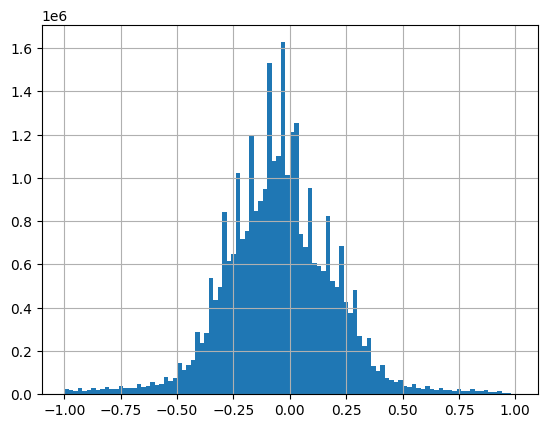

count    3.089629e+07
mean    -4.804081e-02
std      2.434615e-01
min     -1.000000e+00
25%     -1.948052e-01
50%     -4.761905e-02
75%      9.956710e-02
max      1.000000e+00
Name: id, dtype: float64

In [47]:
df_daily['id'].hist(bins=100)
plt.show()
df_daily['id'].describe()

In [61]:
# Copy the DataFrame and drop NaNs
df = df_daily.copy()
df.dropna(subset=['id'], inplace=True)
df.reset_index(drop=True, inplace=True)
df = df[df['prc_lag'] > 5].reset_index(drop=True)
df['id_bins'] = df.groupby('date')['id'].transform(lambda x: pd.qcut(x, 5, labels=False, duplicates='drop') + 1)
grouped = df.groupby(['id_bins'])['id'].mean()

In [62]:
grouped

id_bins
1.0   -0.330109
2.0   -0.157812
3.0   -0.055267
4.0    0.070439
5.0    0.257838
Name: id, dtype: float64

In [55]:
single_table = single_sort(df_daily, signal_name='mom', bins=5, sharpe=True, price_lim=5, freq=252)

In [49]:
results, double_portfolio = double_sort(df_daily, signal1='mom', signal2='id', bins=5, sharpe=True, price_lim=5, freq=126, independent=True)

---Independent Double Sort---
Spread Signal (1): mom
Sort Signal (2): id
Bins: 5
Price Limit: 5
Accumlation Periods: 126


In [56]:
print("-------Single Sort Results-------")
display(single_table.round(4))
print("-------Double Sort Results-------")
display_double(results)

-------Single Sort Results-------


,mom_1,mom_2,mom_3,mom_4,mom_5,Spread
Excess_Ret,-0.0332,0.0681,0.0943,0.1237,0.1796,0.2201
Excess_Std,0.1494,0.1052,0.0933,0.1025,0.1519,0.0935
Sharpe,-0.2225,0.6475,1.0109,1.2073,1.1827,2.3540
Count,6813.0000,6813.0000,6813.0000,6813.0000,6813.0000,6813.0000
T-stat,-18.3634,53.4477,83.4437,99.6475,97.6180,194.3045
P-value,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


-------Double Sort Results-------
Return


,mom_1,mom_2,mom_3,mom_4,mom_5,Spread
id_1,-1.1720,5.8833,6.6644,7.2816,10.9290,12.3960
id_2,2.1607,3.2913,5.0529,6.7092,8.7575,6.4760
id_3,-0.1118,2.4206,3.9315,5.0448,6.9169,7.0365
id_4,-1.7669,2.6900,3.2384,4.2970,6.0702,7.9769
id_5,-3.2481,3.2582,4.4757,5.3301,7.3768,10.9785


Std


,mom_1,mom_2,mom_3,mom_4,mom_5,Spread
id_1,15.4779,9.4871,6.5851,5.2449,8.3691,13.5331
id_2,14.3694,10.5829,8.0441,8.1756,11.7589,10.3727
id_3,13.4675,10.1451,9.1019,9.9857,14.1692,9.1884
id_4,10.6888,8.8388,9.3507,10.9850,14.8559,8.9669
id_5,7.1986,5.5813,6.3292,8.2336,11.6038,8.8068


Sharpe


,mom_1,mom_2,mom_3,mom_4,mom_5,Spread
id_1,-0.0757,0.6201,1.0120,1.3883,1.3059,0.9160
id_2,0.1504,0.3110,0.6282,0.8206,0.7448,0.6243
id_3,-0.0083,0.2386,0.4319,0.5052,0.4882,0.7658
id_4,-0.1653,0.3043,0.3463,0.3912,0.4086,0.8896
id_5,-0.4512,0.5838,0.7071,0.6474,0.6357,1.2466
